In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
load_df = pd.read_csv(f"data\\global_energy_forcasting_2012\\Load_history.csv")
temp_df = pd.read_csv(f"data\\global_energy_forcasting_2012\\temperature_history.csv")

In [3]:
cols = [f"h{c}" for c in range(1, 25)]
load_df[cols] = (
    load_df[cols]
    .replace(",", "", regex=True)  
    .astype(float)                  
)
    
load_df.head()

,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,16853.0,16450.0,16517.0,16873.0,17064.0,17727.0,...,13518.0,13138.0,14130.0,16809.0,18150.0,18235.0,17925.0,16904.0,16162.0,14750.0
1,1,2004,1,2,14155.0,14038.0,14019.0,14489.0,14920.0,16072.0,...,16127.0,15448.0,15839.0,17727.0,18895.0,18650.0,18443.0,17580.0,16467.0,15258.0
2,1,2004,1,3,14439.0,14272.0,14109.0,14081.0,14775.0,15491.0,...,13507.0,13414.0,13826.0,15825.0,16996.0,16394.0,15406.0,14278.0,13315.0,12424.0
3,1,2004,1,4,11273.0,10415.0,9943.0,9859.0,9881.0,10248.0,...,14207.0,13614.0,14162.0,16237.0,17430.0,17218.0,16633.0,15238.0,13580.0,11727.0
4,1,2004,1,5,10750.0,10321.0,10107.0,10065.0,10419.0,12101.0,...,13845.0,14350.0,15501.0,17307.0,18786.0,19089.0,19192.0,18416.0,17006.0,16018.0


In [4]:
load_df_long = load_df.melt(
    id_vars=["zone_id", "year", "month", "day"],  
    value_vars=[f"h{i}" for i in range(1, 25)], 
    var_name="hour", 
    value_name="load"
)

load_df_long["hour"] = load_df_long['hour'].str[1:].astype(int)

load_df_long['date_time'] = pd.to_datetime(load_df_long[['year', 'month', 'day', 'hour']])

load_df_long.head()

,zone_id,year,month,day,hour,load,date_time
0,1,2004,1,1,1,16853.0,2004-01-01 01:00:00
1,1,2004,1,2,1,14155.0,2004-01-02 01:00:00
2,1,2004,1,3,1,14439.0,2004-01-03 01:00:00
3,1,2004,1,4,1,11273.0,2004-01-04 01:00:00
4,1,2004,1,5,1,10750.0,2004-01-05 01:00:00


In [5]:
temp_df_long = temp_df.melt(
    id_vars=["station_id", "year", "month", "day"],  
    value_vars=[f"h{i}" for i in range(1, 25)], 
    var_name="hour", 
    value_name="temp"
)

temp_df_long["hour"] = temp_df_long['hour'].str[1:].astype(int)

temp_df_long['date_time'] = pd.to_datetime(temp_df_long[['year', 'month', 'day', 'hour']])

temp_df_long.head()

,station_id,year,month,day,hour,temp,date_time
0,1,2004,1,1,1,46.0,2004-01-01 01:00:00
1,1,2004,1,2,1,43.0,2004-01-02 01:00:00
2,1,2004,1,3,1,45.0,2004-01-03 01:00:00
3,1,2004,1,4,1,63.0,2004-01-04 01:00:00
4,1,2004,1,5,1,64.0,2004-01-05 01:00:00


In [6]:
load_df_wide = load_df_long.pivot(index='date_time', columns='zone_id', values='load')
load_df_wide.columns = [f"zone_{c}" for c in load_df_wide.columns]

temp_df_wide = temp_df_long.pivot(index='date_time', columns='station_id', values='temp')
temp_df_wide.columns = [f"station_{c}" for c in temp_df_wide.columns]

load_df_wide

,zone_1,zone_2,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9,zone_10,zone_11,zone_12,zone_13,zone_14,zone_15,zone_16,zone_17,zone_18,zone_19,zone_20
date_time,,,,,,,,,,,,,,,,,,,,
2004-01-01 01:00:00,16853.0,126259.0,136233.0,484.0,6829.0,133088.0,136233.0,3124.0,75243.0,23339.0,90700.0,118378.0,20673.0,21791.0,65970.0,28752.0,30645.0,200946.0,82298.0,79830.0
2004-01-01 02:00:00,16450.0,123313.0,133055.0,457.0,6596.0,129909.0,133055.0,2956.0,67368.0,22100.0,86699.0,112480.0,19666.0,21400.0,64600.0,27851.0,30461.0,195835.0,79827.0,77429.0
2004-01-01 03:00:00,16517.0,119192.0,128608.0,450.0,6525.0,125717.0,128608.0,2953.0,64050.0,21376.0,84243.0,108435.0,19020.0,20998.0,63843.0,27631.0,30197.0,194093.0,77728.0,75558.0
2004-01-01 04:00:00,16873.0,117507.0,126791.0,448.0,6654.0,124162.0,126791.0,2914.0,63861.0,21335.0,84285.0,107224.0,18841.0,21214.0,64023.0,27986.0,30264.0,194708.0,76433.0,75709.0
2004-01-01 05:00:00,17064.0,118343.0,127692.0,444.0,6977.0,125320.0,127692.0,3221.0,75852.0,21564.0,86087.0,108870.0,19310.0,21830.0,65679.0,29160.0,30907.0,202458.0,78172.0,77475.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-07-07 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-07 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-07 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df = load_df_wide.join(temp_df_wide, how="inner")

df.head()

,zone_1,zone_2,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9,zone_10,...,station_2,station_3,station_4,station_5,station_6,station_7,station_8,station_9,station_10,station_11
date_time,,,,,,,,,,,,,,,,,,,,,
2004-01-01 01:00:00,16853.0,126259.0,136233.0,484.0,6829.0,133088.0,136233.0,3124.0,75243.0,23339.0,...,38.0,44.0,45.0,42.0,44.0,45.0,43.0,41.0,42.0,36.0
2004-01-01 02:00:00,16450.0,123313.0,133055.0,457.0,6596.0,129909.0,133055.0,2956.0,67368.0,22100.0,...,36.0,42.0,43.0,42.0,43.0,44.0,44.0,39.0,43.0,32.0
2004-01-01 03:00:00,16517.0,119192.0,128608.0,450.0,6525.0,125717.0,128608.0,2953.0,64050.0,21376.0,...,35.0,40.0,41.0,40.0,42.0,41.0,42.0,36.0,43.0,31.0
2004-01-01 04:00:00,16873.0,117507.0,126791.0,448.0,6654.0,124162.0,126791.0,2914.0,63861.0,21335.0,...,30.0,36.0,37.0,39.0,38.0,40.0,34.0,35.0,39.0,30.0
2004-01-01 05:00:00,17064.0,118343.0,127692.0,444.0,6977.0,125320.0,127692.0,3221.0,75852.0,21564.0,...,30.0,34.0,33.0,40.0,38.0,35.0,30.0,33.0,35.0,34.0


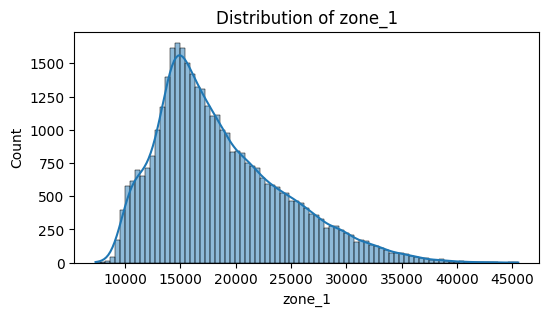

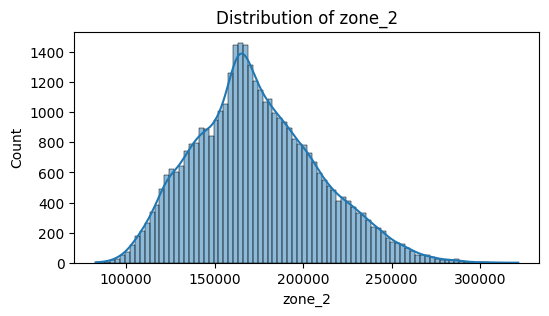

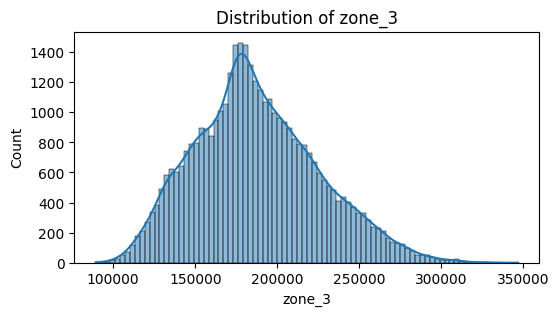

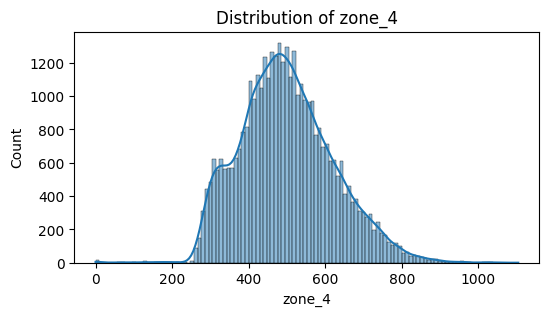

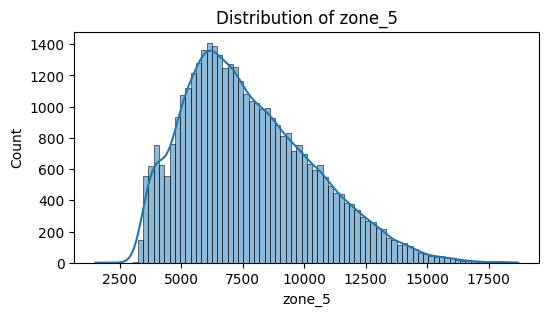

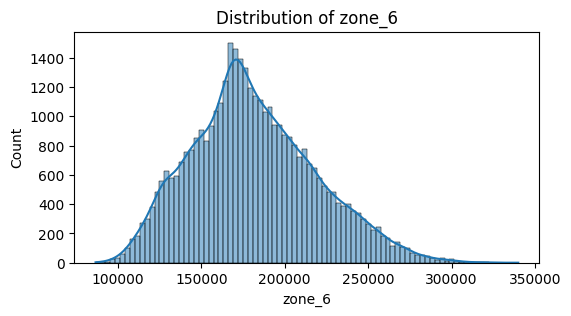

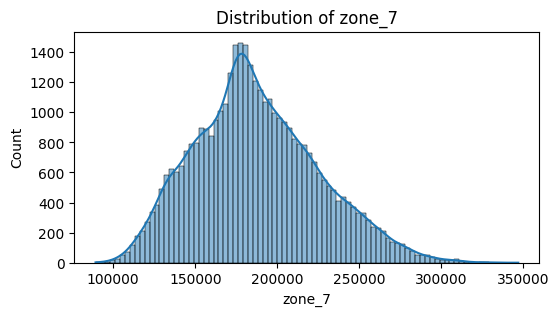

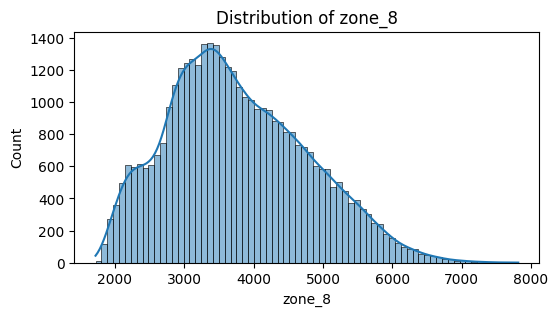

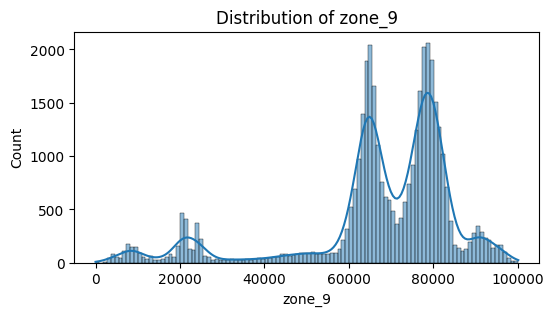

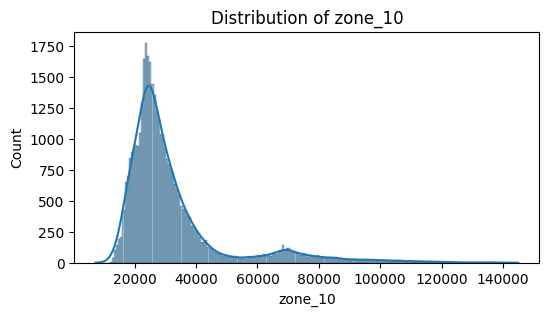

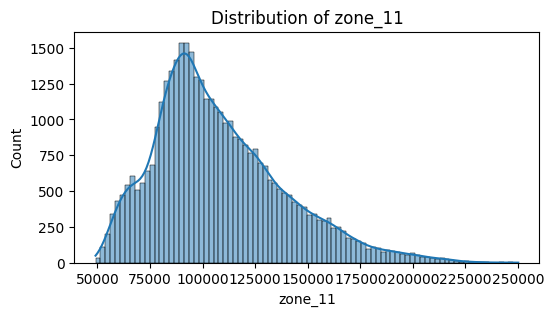

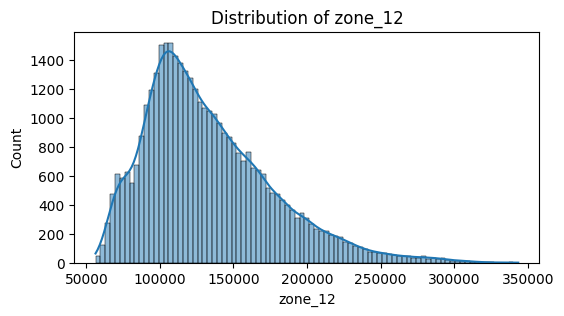

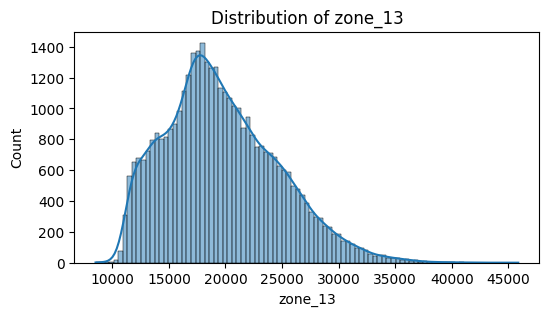

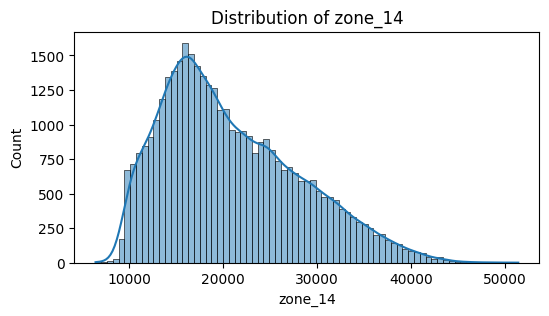

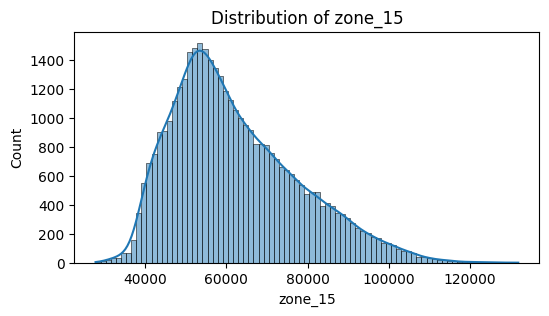

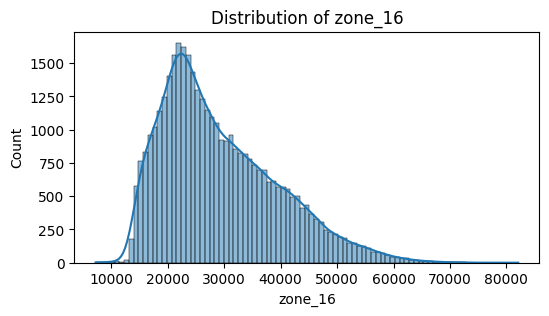

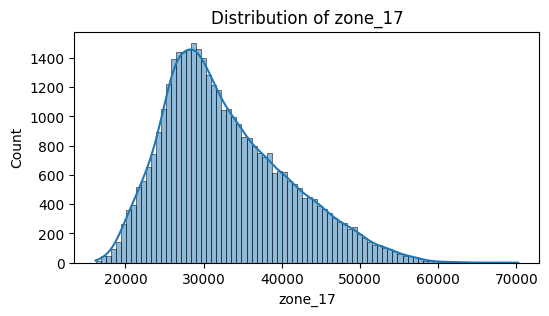

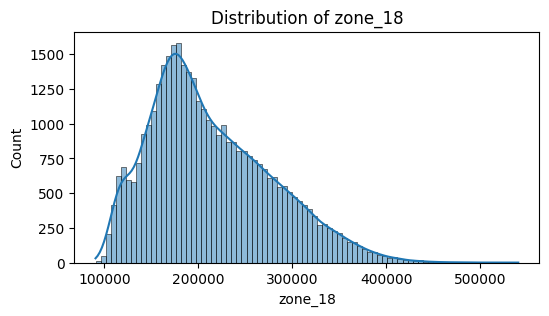

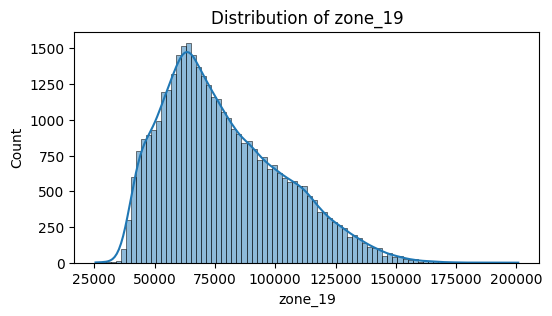

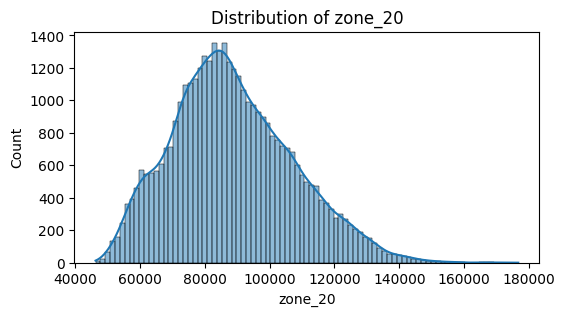

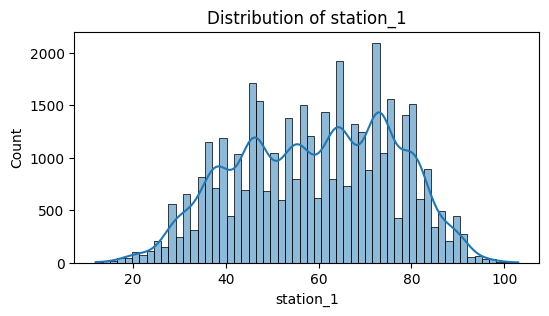

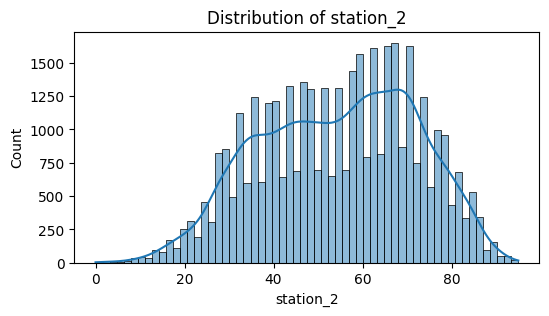

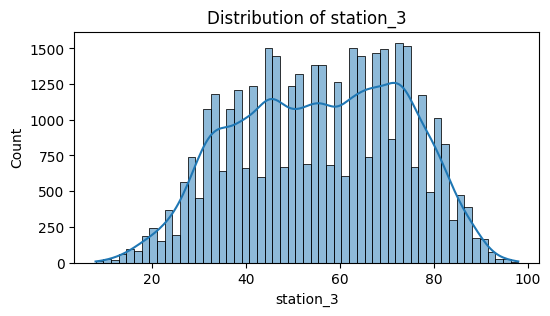

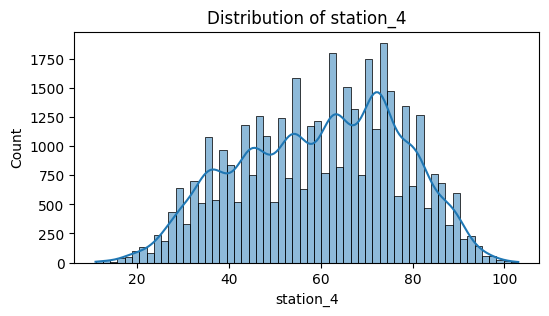

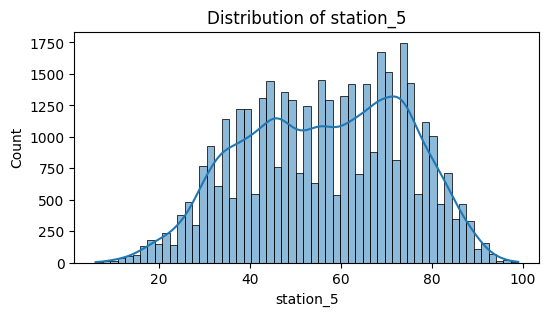

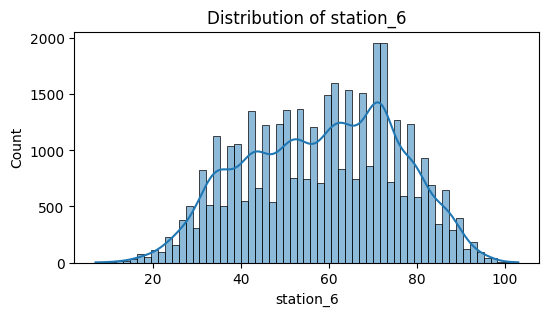

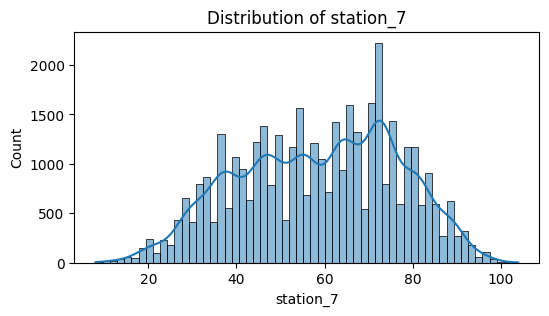

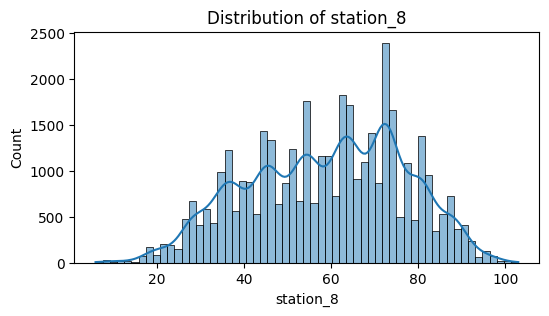

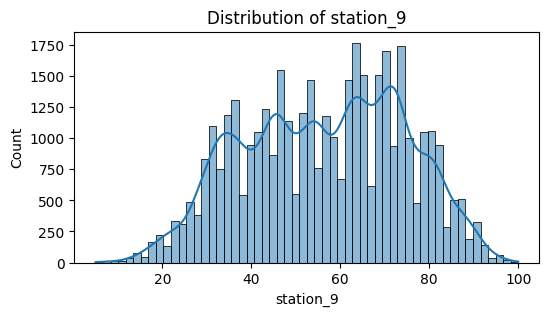

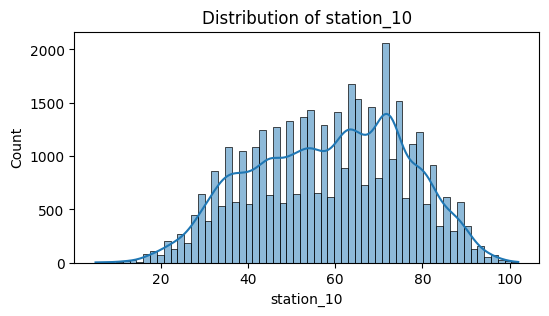

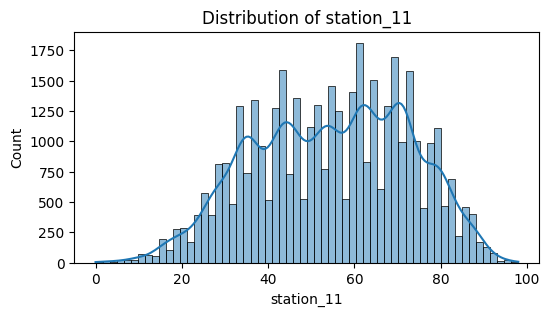

In [8]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

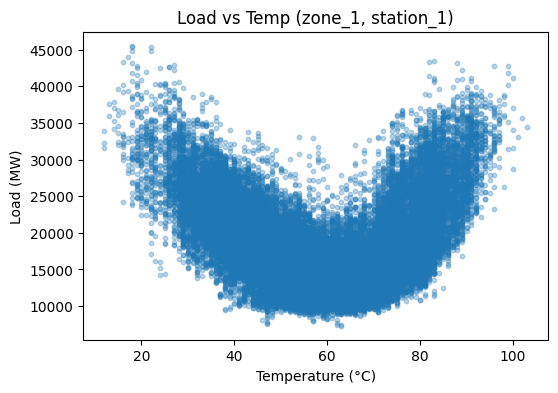

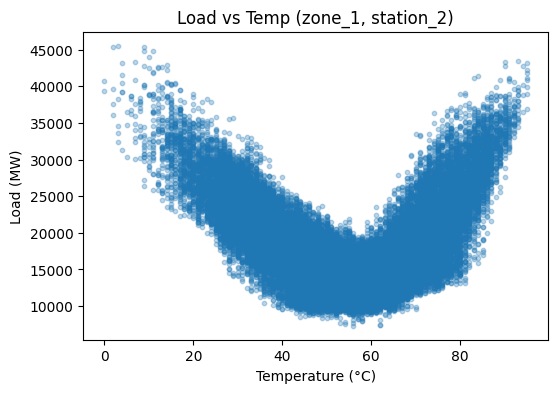

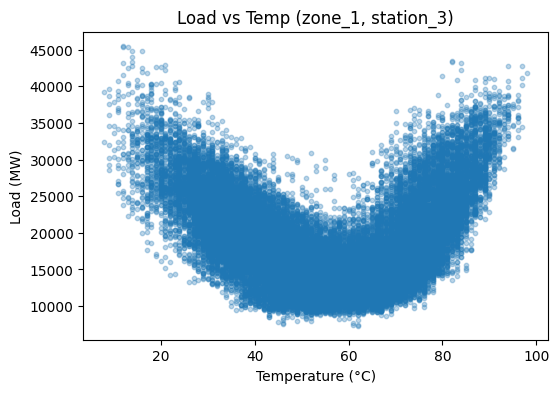

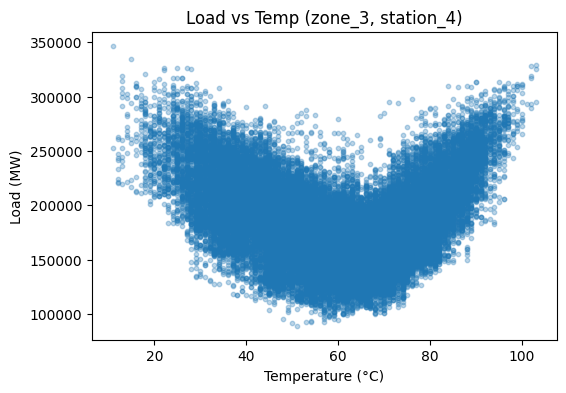

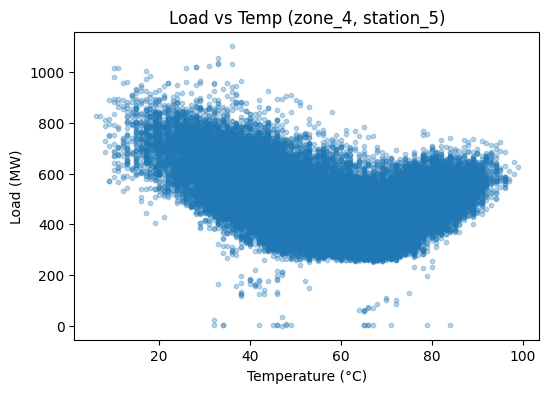

In [9]:
def plot_zone_station_relationship(zone: str, station: str):
    plt.figure(figsize=(6,4))
    plt.scatter(df[station], df[zone], alpha=0.3, s=10)
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Load (MW)")
    plt.title(f"Load vs Temp ({zone}, {station})")
    plt.show()
    
plot_zone_station_relationship("zone_1", "station_1")
plot_zone_station_relationship("zone_1", "station_2")
plot_zone_station_relationship("zone_1", "station_3")
plot_zone_station_relationship("zone_3", "station_4")
plot_zone_station_relationship("zone_4", "station_5")

In [10]:
zones = [c for c in df.columns if c.startswith("zone_")]

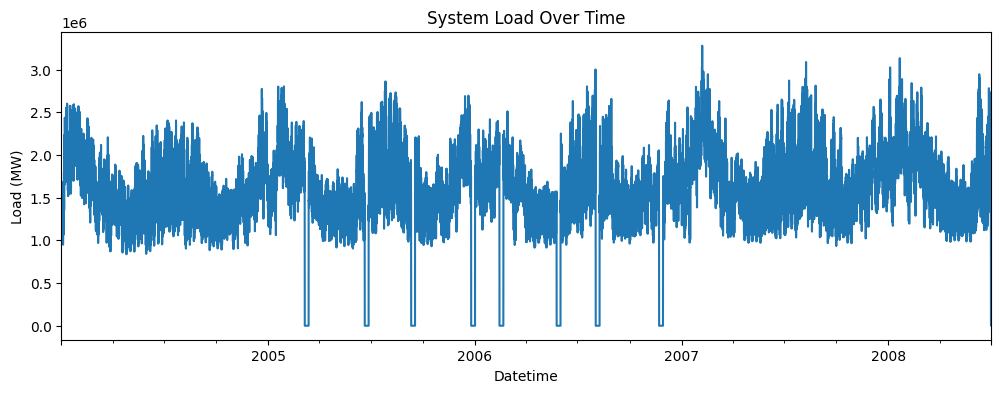

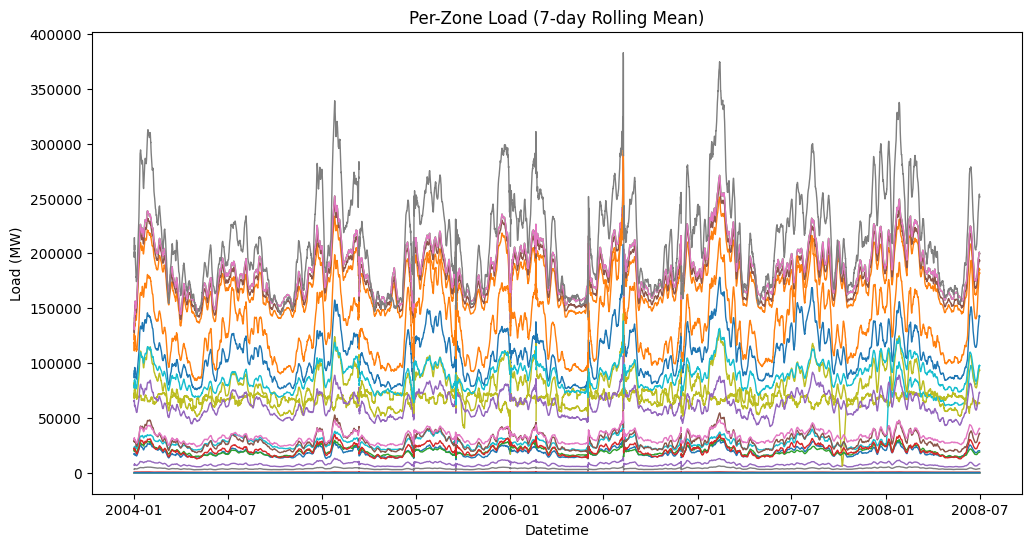

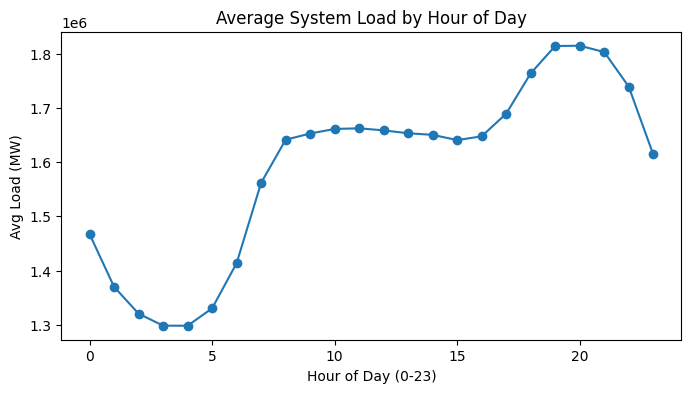

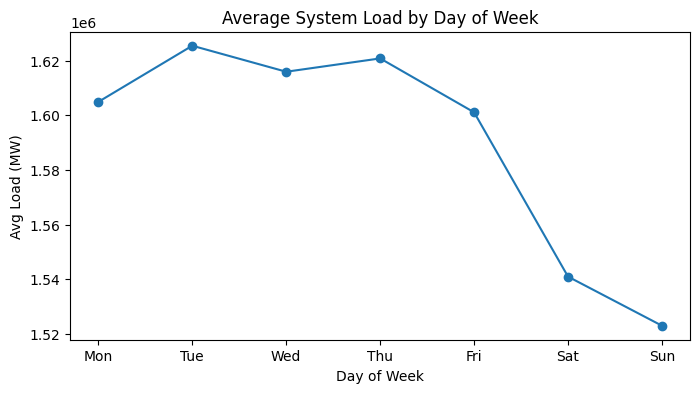

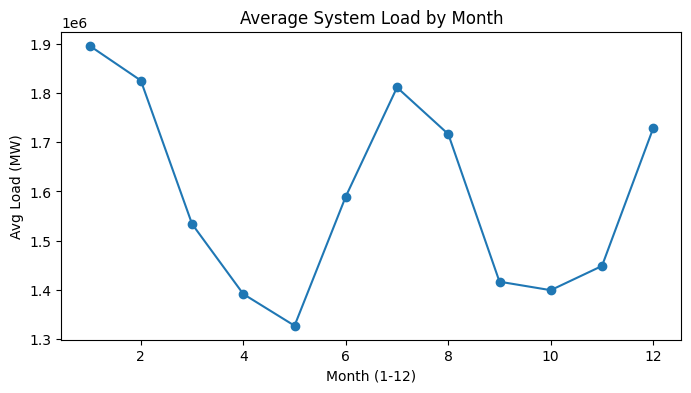

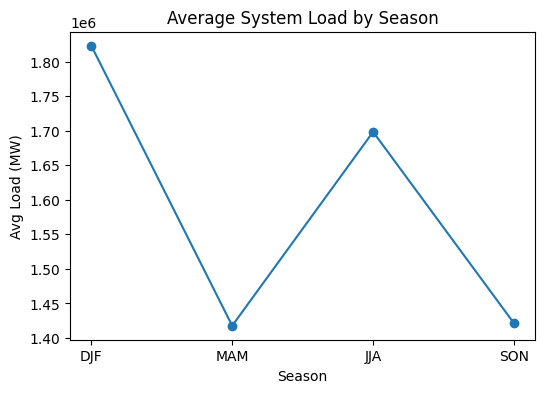

In [11]:
def plot_load_eda(wide):
    """
    wide: DataFrame dạng wide, index = datetime, columns = zone_1..zone_n
    """
    # --- System load (sum across zones) ---
    system_load = wide.loc[:, zones].sum(axis=1)

    # 1. Load theo thời gian (system)
    plt.figure(figsize=(12,4))
    system_load.plot()
    plt.title("System Load Over Time")
    plt.xlabel("Datetime")
    plt.ylabel("Load (MW)")
    plt.show()

    # 2. Load theo zone (rolling mean để đỡ nhiễu)
    roll = wide.rolling(window=24*7, min_periods=1).mean()
    plt.figure(figsize=(12,6))
    
    for c in roll.columns:
        plt.plot(roll.index, roll[c], label=c, linewidth=1)
        
    plt.title("Per-Zone Load (7-day Rolling Mean)")
    plt.xlabel("Datetime")
    plt.ylabel("Load (MW)")
    if roll.shape[1] <= 10:
        plt.legend()
        
    plt.show()

    # 3. Trung bình theo giờ trong ngày
    hod = system_load.groupby(system_load.index.hour).mean()
    plt.figure(figsize=(8,4))
    plt.plot(hod.index, hod.values, marker="o")
    plt.title("Average System Load by Hour of Day")
    plt.xlabel("Hour of Day (0-23)")
    plt.ylabel("Avg Load (MW)")
    plt.show()

    # 4. Trung bình theo ngày trong tuần
    dow = system_load.groupby(system_load.index.dayofweek).mean()
    dow.index = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    plt.figure(figsize=(8,4))
    plt.plot(dow.index, dow.values, marker="o")
    plt.title("Average System Load by Day of Week")
    plt.xlabel("Day of Week")
    plt.ylabel("Avg Load (MW)")
    plt.show()

    # 5. Trung bình theo tháng (seasonality hàng năm)
    mon = system_load.groupby(system_load.index.month).mean()
    plt.figure(figsize=(8,4))
    plt.plot(mon.index, mon.values, marker="o")
    plt.title("Average System Load by Month")
    plt.xlabel("Month (1-12)")
    plt.ylabel("Avg Load (MW)")
    plt.show()

    # 6. Trung bình theo mùa (DJF, MAM, JJA, SON)
    def season_of_month(m):
        if m in (12,1,2): return "DJF"
        if m in (3,4,5):  return "MAM"
        if m in (6,7,8):  return "JJA"
        
        return "SON"
    
    season = system_load.groupby(system_load.index.month.map(season_of_month)).mean()
    season = season.reindex(["DJF","MAM","JJA","SON"])
    plt.figure(figsize=(6,4))
    plt.plot(season.index, season.values, marker="o")
    plt.title("Average System Load by Season")
    plt.xlabel("Season")
    plt.ylabel("Avg Load (MW)")
    plt.show()
    
plot_load_eda(df)

In [12]:
BACKCAST_DATES = [
    ("2005-03-06 00:00:00", "2005-03-12 23:00:00"),
    ("2005-06-20 00:00:00", "2005-06-26 23:00:00"),
    ("2005-09-10 00:00:00", "2005-09-16 23:00:00"),
    ("2005-12-25 00:00:00", "2005-12-31 23:00:00"),
    ("2006-02-13 00:00:00", "2006-02-19 23:00:00"),
    ("2006-05-25 00:00:00", "2006-05-31 23:00:00"),
    ("2006-08-02 00:00:00", "2006-08-08 23:00:00"),
    ("2006-11-22 00:00:00", "2006-11-28 23:00:00"),
]

FORECAST_DATES = ("2008-07-01 00:00:00", "2008-07-07 23:00:00")  

def mask_gefcom2012_hourly(df, drop_forecast_week=True):
    assert isinstance(df.index, pd.DatetimeIndex), "df.index must be DatetimeIndex"
    dates = df.index

    keep = np.ones(len(df), dtype=bool)

    for s, e in BACKCAST_DATES:
        s = pd.to_datetime(s)
        e = pd.to_datetime(e)
        keep &= ~((dates >= s) & (dates <= e))

    if drop_forecast_week:
        s, e = FORECAST_DATES
        s = pd.to_datetime(s)
        e = pd.to_datetime(e)
        keep &= ~((dates >= s) & (dates <= e))

    return df[keep]

def get_gefcom2012_test(df):
    assert isinstance(df.index, pd.DatetimeIndex), "df.index must be DatetimeIndex"
    dates = df.index
    
    test_mask = np.zeros(len(df), dtype=bool)

    # backcast weeks
    for s, e in BACKCAST_DATES:
        s, e = pd.to_datetime(s), pd.to_datetime(e)
        test_mask |= (dates >= s) & (dates <= e)
    
    # forecast week
    s, e = FORECAST_DATES
    s, e = pd.to_datetime(s), pd.to_datetime(e)
    test_mask |= (dates >= s) & (dates <= e)

    return df[test_mask]   # test set

In [13]:
stations = [f"station_{c}" for c in range(1, 12)]
zones = [f"zone_{c}" for c in range(1, 21)]
lags = [1,2,3,6,24]

dfs = {} # dictioary save dataframe for each zone

for zone in zones:
    df_zone = df[stations + [zone]].copy()
    df_zone = mask_gefcom2012_hourly(df_zone)
    
    df_zone["hour"] = df_zone.index.hour
    df_zone["dayofyear"] = df_zone.index.dayofyear
    df_zone["dayofweek"] = df_zone.index.dayofweek

    df_zone = df_zone.rename(columns={zone: "target"})
    df_zone = df_zone.dropna()

    scale_cols = stations + ["target"]

    # hour cyclical
    df_zone["hour_sin"] = np.sin(2*np.pi*df_zone["hour"]/24)
    df_zone["hour_cos"] = np.cos(2*np.pi*df_zone["hour"]/24)

    # weekday cyclical
    df_zone["dow_sin"]  = np.sin(2*np.pi*df_zone["dayofweek"]/7)
    df_zone["dow_cos"]  = np.cos(2*np.pi*df_zone["dayofweek"]/7)

    # day-of-year cyclical (seasonality)
    df_zone["doy_sin"]  = np.sin(2*np.pi*df_zone["dayofyear"]/365)
    df_zone["doy_cos"]  = np.cos(2*np.pi*df_zone["dayofyear"]/365)  

    df_zone.drop(columns=["hour","dayofweek","dayofyear"], axis=1, inplace=True)

    for lag in lags:
        for col in stations:
            df_zone[f"{col}_lag{lag}"] = df_zone[col].shift(lag)
            
    df_zone[f"temp_roll_3h"] = df_zone[stations].mean(axis=1).rolling(window=3).mean().shift(1)
    df_zone[f"temp_roll_24h"] = df_zone[stations].mean(axis=1).rolling(window=24).mean().shift(1)
    
    df_zone = df_zone.dropna().reset_index(drop=True)
    
    dfs[zone] = df_zone
    
dfs['zone_1']

,station_1,station_2,station_3,station_4,station_5,station_6,station_7,station_8,station_9,station_10,...,station_4_lag24,station_5_lag24,station_6_lag24,station_7_lag24,station_8_lag24,station_9_lag24,station_10_lag24,station_11_lag24,temp_roll_3h,temp_roll_24h
0,43.0,45.0,32.0,42.0,36.0,46.0,41.0,45.0,40.0,47.0,...,45.0,42.0,44.0,45.0,43.0,41.0,42.0,36.0,39.757576,43.174242
1,44.0,44.0,33.0,44.0,36.0,47.0,42.0,46.0,41.0,48.0,...,43.0,42.0,43.0,44.0,44.0,39.0,43.0,32.0,40.696970,43.140152
2,46.0,44.0,35.0,45.0,40.0,47.0,43.0,46.0,42.0,48.0,...,41.0,40.0,42.0,41.0,42.0,36.0,43.0,31.0,41.454545,43.178030
3,46.0,45.0,39.0,45.0,42.0,46.0,45.0,46.0,44.0,48.0,...,37.0,39.0,38.0,40.0,34.0,35.0,39.0,30.0,42.393939,43.337121
4,47.0,45.0,41.0,46.0,42.0,47.0,46.0,46.0,44.0,47.0,...,33.0,40.0,38.0,35.0,30.0,33.0,35.0,34.0,43.333333,43.674242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38033,74.0,65.0,76.0,72.0,74.0,70.0,73.0,71.0,72.0,70.0,...,82.0,76.0,76.0,77.0,80.0,74.0,76.0,69.0,72.696970,79.969697
38034,74.0,64.0,76.0,72.0,74.0,70.0,72.0,71.0,72.0,70.0,...,81.0,75.0,75.0,76.0,79.0,74.0,75.0,67.0,71.909091,79.772727
38035,74.0,64.0,75.0,72.0,73.0,70.0,71.0,71.0,69.0,70.0,...,80.0,76.0,75.0,75.0,78.0,73.0,74.0,66.0,71.333333,79.583333
38036,74.0,64.0,75.0,72.0,72.0,70.0,71.0,70.0,69.0,70.0,...,79.0,75.0,75.0,73.0,77.0,72.0,73.0,66.0,70.727273,79.401515


In [14]:
def split_data(df, train_ratio=0.9, val_ratio=0.1):
    """
    Split time series data into train, validation, and test sets.

    Args:
        df (pd.DataFrame): DataFrame with a DatetimeIndex.
        train_ratio (float): Proportion of data for training.
        val_ratio (float): Proportion of data for validation.

    Returns:
        (train_df, val_df, test_df) : tuple of DataFrames
    """
    n = len(df)
    train_end = int(n * train_ratio)

    # Train set: from start until train_end
    train_df = df.iloc[:train_end]
    
    # Test set: the rest of the data
    test_df = df.iloc[train_end:]

    return train_df, test_df

In [15]:
class EnergyDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values
        
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
class EnergyNet(nn.Module):
    def __init__(self, input_dim, hidden_dim: int = 128, output_dim: int = 1):
        super(EnergyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.net(x)
    
class Trainer:
    def __init__(self, model, train_loader, test_loader, lr=1e-3, 
                 weight_decay=1e-4, device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        
    def train_epoch(self):
        self.model.train()
        total_loss = 0
        
        for X, y in self.train_loader:
            X, y = X.to(self.device), y.to(self.device).squeeze()
            
            preds = self.model(X).squeeze()
            loss = self.criterion(preds, y)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item() * len(X)
    
        return total_loss / len(self.train_loader.dataset)
    
    def evaluate(self):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for X, y in self.test_loader:
                X, y = X.to(self.device), y.to(self.device).squeeze()
                preds = self.model(X).squeeze()
                loss = self.criterion(preds, y)
                total_loss += loss.item() * len(X)
                  
        return total_loss / len(self.test_loader)

    def fit(self, zone_level, epochs=100):
        best_loss = float('inf')
        patience = 10
        trigger = 0
        train_losses, test_losses = [], []
        
        for epoch in range(1, epochs + 1):
            train_loss = self.train_epoch()
            test_loss = self.evaluate()
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            if test_loss < best_loss:
                best_loss = test_loss
                trigger = 0
                torch.save(self.model.state_dict(), f"model/{zone_level}/best_model.pt")
            else:
                trigger += 1
                if trigger >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
            
        return {"train_loss": train_losses, "test_loss": test_losses} 

In [17]:
# scaler = RobustScaler()

# for zone in zones:
#     df = dfs[zone]
#     y, X = pd.DataFrame(df['target']), df.drop(['target'], axis=1)
#     X_train, X_test = split_data(X)
#     y_train, y_test = split_data(y)
    
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
#     y_train = scaler.fit_transform(y_train)
#     y_test = scaler.transform(y_test)
    
#     train_ds = EnergyDataset(X_train, y_train)
#     train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)
    
#     test_ds = EnergyDataset(X_test, y_test)
#     test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

#     # model
#     input_dim = X_train.shape[1]  
#     model = EnergyNet(input_dim)

#     # trainer
#     trainer = Trainer(model, train_loader, test_loader, lr=1e-4, weight_decay=1e-5)
#     os.makedirs(f"model/{zone}", exist_ok=True)
#     history = trainer.fit(zone_level=zone, epochs=100)
    
#     plt.figure()
#     plt.plot(history['train_loss'], label='train')
#     plt.plot(history['test_loss'], label='test')
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE Loss')
#     plt.title(f'Loss Curve - Zone {zone}')
#     plt.legend()
#     plt.savefig(f"model/{zone}/loss_curve.png")
#     plt.close()

In [18]:
stations = ['station_1', 'station_2', 'station_3', 'station_4',
    'station_5', 'station_6', 'station_7', 'station_8', 'station_9',
    'station_10', 'station_11']

temps = df[stations]

temps

,station_1,station_2,station_3,station_4,station_5,station_6,station_7,station_8,station_9,station_10,station_11
date_time,,,,,,,,,,,
2004-01-01 01:00:00,46.0,38.0,44.0,45.0,42.0,44.0,45.0,43.0,41.0,42.0,36.0
2004-01-01 02:00:00,46.0,36.0,42.0,43.0,42.0,43.0,44.0,44.0,39.0,43.0,32.0
2004-01-01 03:00:00,45.0,35.0,40.0,41.0,40.0,42.0,41.0,42.0,36.0,43.0,31.0
2004-01-01 04:00:00,41.0,30.0,36.0,37.0,39.0,38.0,40.0,34.0,35.0,39.0,30.0
2004-01-01 05:00:00,39.0,30.0,34.0,33.0,40.0,38.0,35.0,30.0,33.0,35.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...
2008-06-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-30 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
def load_best_model(zone, input_dim, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = EnergyNet(input_dim)
    model.load_state_dict(torch.load(f"model/{zone}/best_model.pt", map_location=device))
    model.to(device)
    model.eval()
    
    return model

for zone in zones:
    model = load_best_model(zone, dfs[zone].shape[1] - 1)
    first_layer_weights = model.net[0].weight.detach().cpu().numpy()  

    station_importance = np.abs(first_layer_weights).sum(axis=0) 
    station_importance = station_importance[:11] 

    top5_idx = station_importance.argsort()[-5:][::-1]
    weights = station_importance[top5_idx] / station_importance[top5_idx].sum()

    proxy_temp = (temps.iloc[:, top5_idx].values * weights).sum(axis=1)
    df[f"{zone}_temp_proxy"] = proxy_temp

In [21]:
df_copy = mask_gefcom2012_hourly(df=df, drop_forecast_week=True).reset_index()  

df_copy['hour'] = df_copy["date_time"].dt.hour
df_copy['day_of_week'] = df_copy["date_time"].dt.dayofweek
df_copy['month'] = df_copy["date_time"].dt.month
df_copy['is_weekend'] = df_copy['day_of_week'].isin([5, 6]).astype(int)

# Hour of day
df_copy["hour_sin"] = np.sin(2 * np.pi * df_copy["hour"] / 24)
df_copy["hour_cos"] = np.cos(2 * np.pi * df_copy["hour"] / 24)

# Day of week
df_copy["dow_sin"] = np.sin(2 * np.pi * df_copy["day_of_week"] / 7)
df_copy["dow_cos"] = np.cos(2 * np.pi * df_copy["day_of_week"] / 7)

# Month
df_copy["month_sin"] = np.sin(2 * np.pi * df_copy["month"] / 12)
df_copy["month_cos"] = np.cos(2 * np.pi * df_copy["month"] / 12)


def season_of_month(month):
    if month in (12,1,2): return "DJF"
    if month in (3,4,5):  return "MAM"
    if month in (6,7,8):  return "JJA"
    
    return "SON"

df_copy["season"] = df_copy["month"].map(season_of_month)

df_copy = df_copy.drop(["hour", "day_of_week", "month"], axis=1)

cal_cols  = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin",
            "month_cos", "is_weekend","season"]
id_cols   = ["date_time"] + cal_cols
zone_cols = [c for c in df_copy.columns if c.startswith("zone_") and not c.endswith("temp_proxy")]
proxy_cols = [c for c in df_copy.columns if c.endswith("_temp_proxy")]

df_long = df_copy[id_cols + zone_cols].melt(
    id_vars=id_cols, 
    value_vars=zone_cols,
    var_name="zone_id", value_name="load"
)

df_proxy = df_copy[id_cols + proxy_cols].melt(
    id_vars=id_cols,
    value_vars=proxy_cols,
    var_name="zone_id", value_name="proxy_temp"
)

df_proxy["zone_id"] = df_proxy["zone_id"].str.replace("_temp_proxy","",regex=False)

df_copy = df_long.merge(
    df_proxy[["date_time", "zone_id", "proxy_temp"]], 
    on=["date_time","zone_id"],
    how="inner")

# ==== Weather features ====
df_copy["CDD"] = (df_copy["proxy_temp"] - 18).clip(lower=0)   # Cooling Degree Days
df_copy["HDD"] = (18 - df_copy["proxy_temp"]).clip(lower=0)   # Heating Degree Days

# ==== Lag & rolling features (per zone) ====
def add_lags_rolls(g):
    g["lag_1"] = g["load"].shift(1)
    g["lag_24"] = g["load"].shift(24)
    g["lag_168"] = g["load"].shift(168)  # 1 week
    
    g["roll_mean_24"] = g["load"].shift(1).rolling(24).mean()
    g["roll_mean_168"] = g["load"].shift(1).rolling(168).mean()
    
    return g

df_copy = df_copy.groupby("zone_id", group_keys=False).apply(add_lags_rolls)

df_copy = df_copy.dropna().reset_index(drop=True)

df_copy.to_csv(r"data\\global_energy_forcasting_2012\\processed\\train.csv")

df_copy.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_5820\3849032229.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_copy = df_copy.groupby("zone_id", group_keys=False).apply(add_lags_rolls)


,date_time,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,is_weekend,season,zone_id,load,proxy_temp,CDD,HDD,lag_1,lag_24,lag_168,roll_mean_24,roll_mean_168
0,2004-01-08 01:00:00,0.258819,0.965926,0.433884,-0.900969,0.5,0.866025,0,DJF,zone_1,25104.0,22.231061,4.231061,0.0,25708.0,26014.0,16853.0,27586.041667,18043.184524
1,2004-01-08 02:00:00,0.500000,0.866025,0.433884,-0.900969,0.5,0.866025,0,DJF,zone_1,25122.0,22.615282,4.615282,0.0,25104.0,26447.0,16450.0,27548.125000,18092.297619
2,2004-01-08 03:00:00,0.707107,0.707107,0.433884,-0.900969,0.5,0.866025,0,DJF,zone_1,25464.0,21.620805,3.620805,0.0,25122.0,27286.0,16517.0,27492.916667,18143.916667
3,2004-01-08 04:00:00,0.866025,0.500000,0.433884,-0.900969,0.5,0.866025,0,DJF,zone_1,25715.0,21.426598,3.426598,0.0,25464.0,27923.0,16873.0,27417.000000,18197.172619
4,2004-01-08 05:00:00,0.965926,0.258819,0.433884,-0.900969,0.5,0.866025,0,DJF,zone_1,26219.0,22.436313,4.436313,0.0,25715.0,29130.0,17064.0,27325.000000,18249.803571


In [22]:
df_test = get_gefcom2012_test(df).reset_index()

df_test = df_test.drop(zone_cols, axis=1)

df_test['hour'] = df_test["date_time"].dt.hour
df_test['day_of_week'] = df_test["date_time"].dt.dayofweek
df_test['month'] = df_test["date_time"].dt.month
df_test['is_weekend'] = df_test['day_of_week'].isin([5, 6]).astype(int)

df_test["season"] = df_test["month"].map(season_of_month)

# Hour of day
df_test["hour_sin"] = np.sin(2 * np.pi * df_test["hour"] / 24)
df_test["hour_cos"] = np.cos(2 * np.pi * df_test["hour"] / 24)

# Day of week
df_test["dow_sin"] = np.sin(2 * np.pi * df_test["day_of_week"] / 7)
df_test["dow_cos"] = np.cos(2 * np.pi * df_test["day_of_week"] / 7)

# Month
df_test["month_sin"] = np.sin(2 * np.pi * df_test["month"] / 12)
df_test["month_cos"] = np.cos(2 * np.pi * df_test["month"] / 12)

df_test = df_test.drop(["hour", "month", "day_of_week"], axis=1)

df_proxy = df_test[id_cols + proxy_cols].melt(
    id_vars=id_cols,
    value_vars=proxy_cols,
    var_name="zone_id", value_name="proxy_temp"
)

df_proxy["zone_id"] = df_proxy["zone_id"].str.replace("_temp_proxy","", regex=False)

df_proxy["CDD"] = (df_proxy["proxy_temp"] - 18).clip(lower=0)
df_proxy["HDD"] = (18 - df_proxy["proxy_temp"]).clip(lower=0)

df_proxy.to_csv(r"data\\global_energy_forcasting_2012\\processed\\test.csv")
df_proxy.head()

,date_time,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,is_weekend,season,zone_id,proxy_temp,CDD,HDD
0,2005-03-06 00:00:00,0.000000,1.000000,-0.781831,0.62349,1.0,6.123234e-17,1,MAM,zone_1,30.188479,12.188479,0.0
1,2005-03-06 01:00:00,0.258819,0.965926,-0.781831,0.62349,1.0,6.123234e-17,1,MAM,zone_1,30.024097,12.024097,0.0
2,2005-03-06 02:00:00,0.500000,0.866025,-0.781831,0.62349,1.0,6.123234e-17,1,MAM,zone_1,30.423760,12.423760,0.0
3,2005-03-06 03:00:00,0.707107,0.707107,-0.781831,0.62349,1.0,6.123234e-17,1,MAM,zone_1,30.011251,12.011251,0.0
4,2005-03-06 04:00:00,0.866025,0.500000,-0.781831,0.62349,1.0,6.123234e-17,1,MAM,zone_1,30.494184,12.494184,0.0
